In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [31]:
import numpy as np
import pandas as pd
from scipy import stats
import json
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import balanced_accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# All the functions
def load_data_frame(difficulties_json_file):
    """
    Loads difficulties json file as pandas DataFrame.

    Parameters
    ----------
    difficulties_json_file
    difficulties data (e.g., generated with difficulty_calculators.py)

    Returns
    -------
    pandas DataFrame
    """
    df = pd.read_json(difficulties_json_file, orient='record')
    df['grade'] = pd.to_numeric(df['grade']) - 1
    df['id'] = df['id'].astype(str)
    return df


def correlations(df, titles):
    correlations = []
    for feature in titles:
        spearmanr = stats.spearmanr(df.grade.tolist(), df[feature].tolist())
        tauc = stats.kendalltau(df.grade.tolist(), df[feature].tolist(), variant='c')
        # taub = stats.kendalltau(df.grade.tolist(), df[feature].tolist(), variant='b')
        # spearmanr = stats.spearmanr(df.grade.tolist(), df[feature].tolist())
        entry = {
            "feature": feature,
            "tau_c": tauc.correlation,
            "tauc_pvalue": tauc.pvalue,
            "r": spearmanr.correlation,
            "r_pvalue": spearmanr.pvalue
        }
        correlations.append(entry)

    correlations = pd.DataFrame(correlations)
    return correlations.sort_values(by=['tau_c'], ascending=False)

def compute_metrics(model, train_df, test_df, predictive_columns):
    X_train = train_df.loc[:, predictive_columns]
    X_test = test_df.loc[:, predictive_columns]
    y_train = train_df.grade
    y_test = test_df.grade
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    bacc_train = balanced_accuracy_score(y_pred=train_pred, y_true=y_train)
    bacc_test = balanced_accuracy_score(y_pred=test_pred, y_true=y_test)
    mse_train = mean_squared_error(y_pred=train_pred, y_true=y_train)
    mse_test = mean_squared_error(y_pred=test_pred, y_true=y_test)
    mask = [0, 0, 0, 1, 1, 1, 2, 2, 2]
    bacc3_train = balanced_accuracy_score(y_pred=[mask[yy] for yy in train_pred], y_true=[mask[yy] for yy in y_train])
    bacc3_test = balanced_accuracy_score(y_pred=[mask[yy] for yy in test_pred], y_true=[mask[yy] for yy in y_test])
    matches = [1 if pp in [tt-1, tt, tt+1] else 0 for tt, pp in zip(y_train, train_pred)]
    acc_plusless_1_train = sum(matches) / len(matches)
    matches = [1 if pp in [tt-1, tt, tt+1] else 0 for tt, pp in zip(y_test, test_pred)]
    acc_plusless_1_test = sum(matches) / len(matches)
    res = {
            'bacc': {
                'train': bacc_train,
                'test': bacc_test
            },
            '3bacc': {
                'train': bacc3_train,
                'test': bacc3_test
            },
            'acc_plusless_1': {
                'train': acc_plusless_1_train,
                'test': acc_plusless_1_test
            },
            'mse': {
                'train': mse_train,
                'test': mse_test,
            }
        }
    return res

def train_and_validate(df, predictive_columns, train_ids, test_ids, var_smoothing=None):
    train_df =df[df['id'].isin(train_ids)]
    train_X = train_df.loc[:, predictive_columns]
    train_y = train_df.grade
    if var_smoothing is None:
        model = GaussianNB()
    else:
        model = GaussianNB(var_smoothing=var_smoothing)
    model.fit(train_X, train_y)
    test_df=df[df['id'].isin(test_ids)]
    res = compute_metrics(model, train_df, test_df, predictive_columns)
    return res["bacc"]["train"], res["bacc"]["test"], res

def estimate_var_smoothing(df, predictive_columns):
    train_df = df[df['id'].isin(train_set)]
    x_train = df.loc[:, predictive_columns]
    y_train = df.grade
    nb_classifier = GaussianNB()
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    gs_NB = GridSearchCV(estimator=nb_classifier, 
                     param_grid=params_NB, 
                     scoring='accuracy') 
    gs_NB.fit(x_train, y_train)
    return gs_NB.best_params_['var_smoothing']


def fit_columns(df, all_predictive_columns, train_ids, validation_ids):
    results=[]
    max_val_acc = 0
    max_id = ''
    for c in range(1, 2**len(all_predictive_columns)):
        predictive_columns = []
        for i in range(0, len(all_predictive_columns)):
            if 1<<i & c:
                predictive_columns.append(all_predictive_columns[i])
        id = ", ".join(predictive_columns)
        train_acc, val_acc, _ = train_and_validate(df, predictive_columns=predictive_columns, train_ids=train_ids, test_ids=validation_ids)
        results.append({'id': id, 'training':train_acc, 'val':val_acc})
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            max_id = id
        if c % 1000 == 0:
            print(c, max_val_acc, max_id)
    return results

In [32]:
# loading dataset.
# TODO: propert path to index_clean.json

df = load_data_frame('old_school_features.json')

with open("../../henle_xml_dataset/henleXmus/index_clean.json") as f:
    index = json.load(f)

train_set = set()
val_set = set()
test_set = set()
split_set = set()

for p_id in df["id"].tolist():
    if index[p_id]['subset']  == 'train':
        train_set.add(p_id)
    elif index[p_id]['subset']  == 'val':
        val_set.add(p_id)
    elif index[p_id]['subset'] == 'test':
        test_set.add(p_id)
    elif index[p_id]['subset'] == 'split':
        split_set.add(p_id)

train_val_set=set()
train_val_set.update(train_set)
train_val_set.update(val_set)

df 

,time_signature,pitch_entropy,pitch_class_entropy,pitch_set_entropy,pitch_class_set_entropy,rh_pitch_range,lh_pitch_range,articulations,avg_chord_density,max_chord_density,tuplets,lh_lhl,rh_lhl,lhl_sum,id,grade
0,2,6.423700,3.556575,9.085868,6.049889,56,57,0.431976,2.529428,5,0.063761,154,277,263,5713806,8
1,2,4.881558,3.119320,6.589386,4.580054,36,37,0.235677,2.126638,3,0.376854,74,45,109,6332296,3
2,3,4.164499,2.873959,4.756620,3.819416,21,21,-0.000000,0.000000,1,0.023077,0,0,0,6191144,0
3,4,4.633865,2.942034,5.901803,4.319265,31,40,-0.000000,2.500000,4,0.976501,1,3,4,6332015,5
4,3,5.372285,3.147354,6.740099,4.855691,44,43,0.303571,2.408537,4,0.000000,2,22,23,6106915,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,4,5.691263,3.371689,7.081036,4.988313,43,55,0.372935,2.532646,4,0.000000,206,64,179,6351390,6
539,3,5.609379,3.431607,8.967100,7.113937,50,47,0.957571,2.577756,4,0.039644,265,246,284,6114842,8
540,1,4.819046,2.979356,7.071621,4.777002,45,41,0.541733,2.200883,3,0.105718,62,49,89,4305816,4
541,1,6.090768,3.535198,8.707475,6.689135,55,64,0.297706,2.143443,4,0.002613,206,295,189,2603306,8


In [33]:
# Correlations
features = [
    'time_signature',
    'pitch_entropy',
    'pitch_class_entropy',
    'pitch_set_entropy',
    'pitch_class_set_entropy',
    'rh_pitch_range',
    'lh_pitch_range',
    'articulations',
    'avg_chord_density',
    'max_chord_density',
    'tuplets',
    'lh_lhl',
    'rh_lhl',
    'lhl_sum']
cc = correlations(df, features)
cc

,feature,tau_c,tauc_pvalue,r,r_pvalue
1,pitch_entropy,0.595456,4.863616e-78,0.724756,1.420965e-89
5,rh_pitch_range,0.591626,3.852192e-77,0.725384,8.447143e-90
6,lh_pitch_range,0.561590,1.101339e-69,0.684004,3.880961e-76
2,pitch_class_entropy,0.513026,2.096705e-58,0.634099,2.058030e-62
3,pitch_set_entropy,0.505578,8.968363e-57,0.617445,2.240849e-58
13,lhl_sum,0.435121,1.600625e-42,0.556649,1.662133e-45
4,pitch_class_set_entropy,0.430367,1.256122e-41,0.532411,4.458721e-41
9,max_chord_density,0.430199,2.830593e-44,0.579687,4.573148e-50
12,rh_lhl,0.420195,8.369167e-40,0.535332,1.362478e-41
11,lh_lhl,0.418203,1.731760e-39,0.537108,6.590006e-42


In [34]:
for index, row in cc.iterrows():
    print(
        "\\begin{tabular}[c]{@{}l@{}}\\textit{%s}. \\end{tabular} & %.2f // \\hline" % (row["feature"].replace("_","\\_"), row["tau_c"]))

\begin{tabular}[c]{@{}l@{}}\textit{pitch\_entropy}. \end{tabular} & 0.60 // \hline
\begin{tabular}[c]{@{}l@{}}\textit{rh\_pitch\_range}. \end{tabular} & 0.59 // \hline
\begin{tabular}[c]{@{}l@{}}\textit{lh\_pitch\_range}. \end{tabular} & 0.56 // \hline
\begin{tabular}[c]{@{}l@{}}\textit{pitch\_class\_entropy}. \end{tabular} & 0.51 // \hline
\begin{tabular}[c]{@{}l@{}}\textit{pitch\_set\_entropy}. \end{tabular} & 0.51 // \hline
\begin{tabular}[c]{@{}l@{}}\textit{lhl\_sum}. \end{tabular} & 0.44 // \hline
\begin{tabular}[c]{@{}l@{}}\textit{pitch\_class\_set\_entropy}. \end{tabular} & 0.43 // \hline
\begin{tabular}[c]{@{}l@{}}\textit{max\_chord\_density}. \end{tabular} & 0.43 // \hline
\begin{tabular}[c]{@{}l@{}}\textit{rh\_lhl}. \end{tabular} & 0.42 // \hline
\begin{tabular}[c]{@{}l@{}}\textit{lh\_lhl}. \end{tabular} & 0.42 // \hline
\begin{tabular}[c]{@{}l@{}}\textit{tuplets}. \end{tabular} & 0.30 // \hline
\begin{tabular}[c]{@{}l@{}}\textit{avg\_chord\_density}. \end{tabular} & 0.25 // 

In [67]:
results = fit_columns(df, features, train_set, val_set)

1000 0.5129047365889471 pitch_entropy, pitch_class_entropy, rh_pitch_range, lh_pitch_range, max_chord_density
2000 0.5129047365889471 pitch_entropy, pitch_class_entropy, rh_pitch_range, lh_pitch_range, max_chord_density
3000 0.5285314506805735 time_signature, pitch_entropy, pitch_class_entropy, rh_pitch_range, articulations, lh_lhl
4000 0.5285314506805735 time_signature, pitch_entropy, pitch_class_entropy, rh_pitch_range, articulations, lh_lhl
5000 0.5285314506805735 time_signature, pitch_entropy, pitch_class_entropy, rh_pitch_range, articulations, lh_lhl
6000 0.5285314506805735 time_signature, pitch_entropy, pitch_class_entropy, rh_pitch_range, articulations, lh_lhl
7000 0.5285314506805735 time_signature, pitch_entropy, pitch_class_entropy, rh_pitch_range, articulations, lh_lhl
8000 0.5285314506805735 time_signature, pitch_entropy, pitch_class_entropy, rh_pitch_range, articulations, lh_lhl
9000 0.5285314506805735 time_signature, pitch_entropy, pitch_class_entropy, rh_pitch_range, arti

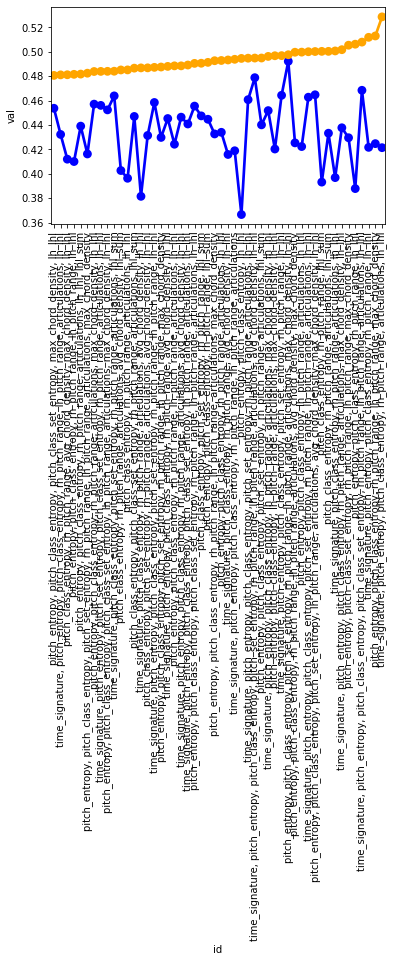

In [68]:
top_validation = pd.DataFrame(sorted(results, key = lambda x: x['val'])[-50:])
fig, ax = plt.subplots()
sns.pointplot(x="id", y="training", data=top_validation, ax=ax, color="blue", label="training")
sns.pointplot(x="id", y="val", data=top_validation, ax=ax, color="orange", label="validation")
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical');
plt.show()


In [70]:
results = sorted(results, key=lambda x : x["val"])
validation_selected_features = results[-1]["id"].split(", ")
validation_selected_features

['time_signature',
 'pitch_entropy',
 'pitch_class_entropy',
 'rh_pitch_range',
 'articulations',
 'lh_lhl']

In [71]:
print(", ".join(["\\textit{%s}" % x.replace("_", "\\_") for x in validation_selected_features]))

\textit{time\_signature}, \textit{pitch\_entropy}, \textit{pitch\_class\_entropy}, \textit{rh\_pitch\_range}, \textit{articulations}, \textit{lh\_lhl}


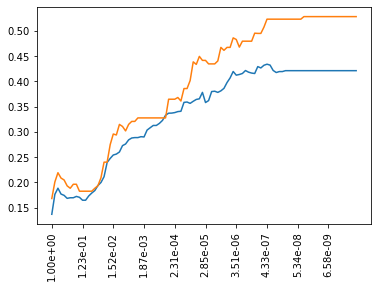

In [72]:
# Effect of variation smoothing: better without smoothing.

train_accs = []
val_means = []
smoothings = np.logspace(0,-9, num=100)
for smoothing in smoothings:
    train_acc, val_acc, _ = train_and_validate(df, predictive_columns = validation_selected_features, train_ids=train_set, test_ids=val_set, var_smoothing=smoothing)
    train_accs.append(train_acc)
    val_means.append(val_acc)
    
plt.plot(train_accs)
plt.plot(val_means)
plt.xticks(np.arange(0, len(smoothings), 10), ['{:.2e}'.format(x) for x in smoothings[0:-1:10]], rotation='vertical');

In [73]:
_, _, res = train_and_validate(df, predictive_columns = validation_selected_features, train_ids=train_set, test_ids=val_set)
print(json.dumps(res, indent=4))

{
    "bacc": {
        "train": 0.42140348117583754,
        "test": 0.5285314506805735
    },
    "3bacc": {
        "train": 0.6754035512510089,
        "test": 0.752297410192147
    },
    "acc_plusless_1": {
        "train": 0.7491749174917491,
        "test": 0.8076923076923077
    },
    "mse": {
        "train": 1.8943894389438944,
        "test": 1.75
    }
}


In [74]:
_, _, res = train_and_validate(df, predictive_columns = validation_selected_features, train_ids=train_val_set, test_ids=test_set)
print(json.dumps(res, indent=4))

{
    "bacc": {
        "train": 0.4347020242422541,
        "test": 0.27647707231040564
    },
    "3bacc": {
        "train": 0.6781972507778958,
        "test": 0.5722928009679371
    },
    "acc_plusless_1": {
        "train": 0.7641277641277642,
        "test": 0.6509433962264151
    },
    "mse": {
        "train": 1.746928746928747,
        "test": 2.6792452830188678
    }
}


In [75]:
_, _, res = train_and_validate(df, predictive_columns = validation_selected_features, train_ids=train_val_set, test_ids=split_set)
print(json.dumps(res, indent=4))

{
    "bacc": {
        "train": 0.4347020242422541,
        "test": 0.4333333333333333
    },
    "3bacc": {
        "train": 0.6781972507778958,
        "test": 0.675
    },
    "acc_plusless_1": {
        "train": 0.7641277641277642,
        "test": 0.7666666666666667
    },
    "mse": {
        "train": 1.746928746928747,
        "test": 1.8
    }
}


/Users/seva/MTG/TrinityPipeline/code/score_analyser/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/seva/MTG/TrinityPipeline/code/score_analyser/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [76]:
split_set

{'117422',
 '176379',
 '1965746',
 '274576',
 '4274056',
 '4282246',
 '4300571',
 '4337031',
 '480961',
 '4941561',
 '5053472',
 '5253996',
 '5612298',
 '5667580',
 '5684198',
 '5687073',
 '5955400',
 '6182418',
 '6183825',
 '6207140',
 '6242571',
 '6251778',
 '6252683',
 '6265735',
 '6295986',
 '6360575',
 '6385908',
 '6408241',
 '690386',
 '724906'}